## 네이버 주식 데이터 크롤링하기

In [1]:
import requests
import bs4
import pandas as pd
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
import time
from tqdm.notebook import tqdm
import warnings
warnings.simplefilter('ignore')

In [22]:
source = ""
for page_no in tqdm(range(1, 6)):  # 5페이지
    page_url = f"https://finance.naver.com/sise/sise_index_day.naver?code=KPI200&page={page_no}"

    source += requests.get(page_url).text
    time.sleep(1)
    
source

  0%|          | 0/5 [00:00<?, ?it/s]

'<html lang="ko">\n<head>\n<meta http-equiv="Content-Type" content="text/html; charset=euc-kr">\n<title>네이버 증권</title>\n\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/newstock.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/common.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/layout.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/main.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/newstock2.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/newstock3.css">\n<link rel="stylesheet" type="text/css" href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/world.css">\n</head>\n<body>\n<script t

In [23]:
source = bs4.BeautifulSoup(source)

In [25]:
print(source.prettify())

<html lang="ko">
 <head>
  <meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
  <title>
   네이버 증권
  </title>
  <link href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/newstock.css" rel="stylesheet" type="text/css"/>
  <link href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/common.css" rel="stylesheet" type="text/css"/>
  <link href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/layout.css" rel="stylesheet" type="text/css"/>
  <link href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/main.css" rel="stylesheet" type="text/css"/>
  <link href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/newstock2.css" rel="stylesheet" type="text/css"/>
  <link href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/newstock3.css" rel="stylesheet" type="text/css"/>
  <link href="https://ssl.pstatic.net/imgstock/static.pc/20230109162011/css/world.css" rel="stylesheet" type="text/css"/>
 </head

In [30]:
table = source.find_all('td', class_='number_1')
table

[<td class="number_1">314.21</td>,
 <td class="number_1">
 <span class="tah p11 red01">
 				+0.13%
 				</span>
 </td>,
 <td class="number_1" style="padding-right:40px;">42,573</td>,
 <td class="number_1" style="padding-right:30px;">2,178,373</td>,
 <td class="number_1">313.81</td>,
 <td class="number_1">
 <span class="tah p11 red01">
 				+0.61%
 				</span>
 </td>,
 <td class="number_1" style="padding-right:40px;">86,249</td>,
 <td class="number_1" style="padding-right:30px;">4,301,694</td>,
 <td class="number_1">311.91</td>,
 <td class="number_1">
 <span class="tah p11 nv01">
 				-0.59%
 				</span>
 </td>,
 <td class="number_1" style="padding-right:40px;">93,051</td>,
 <td class="number_1" style="padding-right:30px;">4,402,572</td>,
 <td class="number_1">313.75</td>,
 <td class="number_1">
 <span class="tah p11 nv01">
 				-0.72%
 				</span>
 </td>,
 <td class="number_1" style="padding-right:40px;">101,245</td>,
 <td class="number_1" style="padding-right:30px;">4,829,876</td>,
 

In [27]:
dates = source.find_all("td", class_="date")
dates

[<td class="date">2023.01.20</td>,
 <td class="date">2023.01.19</td>,
 <td class="date">2023.01.18</td>,
 <td class="date">2023.01.17</td>,
 <td class="date">2023.01.16</td>,
 <td class="date">2023.01.13</td>]

In [28]:
date_list = []
for date in dates:
    date_list.append(date.text)
date_list

['2023.01.20',
 '2023.01.19',
 '2023.01.18',
 '2023.01.17',
 '2023.01.16',
 '2023.01.13']

In [34]:
price_list = []

for price in table[::4]:
    price_list.append(price.text)
price_list

['314.21', '313.81', '311.91', '313.75', '316.04', '313.77']

In [40]:
last_url = source.find_all('td', class_="pgRR")[0].find_all('a')[0]['href']
last_url

'/sise/sise_index_day.naver?code=KPI200&page=703'

In [41]:
last_page = int(last_url.split('&page=')[-1])
last_page

703

## 가져온 정보를 하나로 합쳐서 구현하기
1. 일별 시세 정보가 있는 페이지에 접속
2. 페이지에서 날짜 / 체결가가 들어있는 태그를 검색한다.
3. 태그 중에서 우리가 찾는 조건에 맞는 데이터만 가져온다.
4. 이를 원하는 만큼 반복한다.

In [44]:
date_list = []
price_list = []

for page_no in tqdm(range(1, last_page)):  # 5페이지
    page_url = f"https://finance.naver.com/sise/sise_index_day.naver?code=KPI200&page={page_no}"

    source = requests.get(page_url).text
    source = bs4.BeautifulSoup(source)
    
    dates = source.find_all("td", class_="date")
    
    for date in dates:
        date_list.append(date.text)
        
    table = source.find_all('td', class_='number_1')
    
    for price in table[::4]:
        price_list.append(price.text)
    
    time.sleep(1)
    

  0%|          | 0/702 [00:00<?, ?it/s]

In [45]:
df = pd.DataFrame({"date": date_list,
                  "price": price_list}).dropna()

In [46]:
df

,date,price
0,2023.01.20,314.63
1,2023.01.19,313.81
2,2023.01.18,311.91
3,2023.01.17,313.75
4,2023.01.16,316.04
...,...,...
4207,2006.01.13,181.71
4208,2006.01.12,179.65
4209,2006.01.11,178.67
4210,2006.01.10,178.98


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

<AxesSubplot: xlabel='date', ylabel='price'>

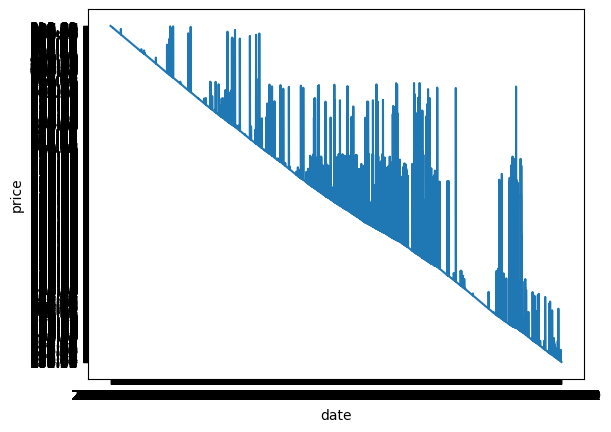

In [54]:
sns.lineplot(data=df, x="date", y="price")

In [48]:
df.to_csv("stock.csv", index=False)